First, load the data,in this notebook we are using the smokoy mountain data as the example

In [1]:
import sys
sys.path.append('./Code')
import loadData 
import RunML
import FS

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("./Data/merge_proportion_asv_smoky_moutain.csv")

In [3]:
data

array([[1.5786533e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6912335e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0700000e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.2400000e-05, 8.2400000e-05],
       [1.5771320e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [4]:
ASVs

['ASV1',
 'ASV2',
 'ASV3',
 'ASV4',
 'ASV5',
 'ASV6',
 'ASV7',
 'ASV8',
 'ASV9',
 'ASV11',
 'ASV12',
 'ASV13',
 'ASV15',
 'ASV17',
 'ASV18',
 'ASV19',
 'ASV20',
 'ASV21',
 'ASV23',
 'ASV24',
 'ASV26',
 'ASV27',
 'ASV30',
 'ASV31',
 'ASV32',
 'ASV34',
 'ASV35',
 'ASV37',
 'ASV38',
 'ASV39',
 'ASV42',
 'ASV43',
 'ASV44',
 'ASV45',
 'ASV46',
 'ASV47',
 'ASV48',
 'ASV49',
 'ASV50',
 'ASV51',
 'ASV52',
 'ASV53',
 'ASV54',
 'ASV58',
 'ASV59',
 'ASV60',
 'ASV61',
 'ASV62',
 'ASV63',
 'ASV64',
 'ASV65',
 'ASV66',
 'ASV67',
 'ASV70',
 'ASV72',
 'ASV73',
 'ASV74',
 'ASV75',
 'ASV76',
 'ASV77',
 'ASV79',
 'ASV80',
 'ASV81',
 'ASV82',
 'ASV85',
 'ASV86',
 'ASV87',
 'ASV88',
 'ASV89',
 'ASV90',
 'ASV91',
 'ASV93',
 'ASV94',
 'ASV95',
 'ASV97',
 'ASV98',
 'ASV99',
 'ASV100',
 'ASV102',
 'ASV103',
 'ASV104',
 'ASV105',
 'ASV106',
 'ASV108',
 'ASV109',
 'ASV110',
 'ASV111',
 'ASV112',
 'ASV113',
 'ASV114',
 'ASV117',
 'ASV118',
 'ASV119',
 'ASV120',
 'ASV121',
 'ASV122',
 'ASV126',
 'ASV128',
 'ASV129

In [4]:
data=RunML.normalizingMatrixToRanks(data,cutOff=0.01)
print(np.shape(data))

(59, 1768)


In [5]:
print(burn_label)
print(un_label)
print(duration_label)

0      No
1      No
2      No
3      No
4      No
5      No
6      No
7     Yes
8     Yes
9     Yes
10    Yes
11    Yes
12    Yes
13    Yes
14    Yes
15    Yes
16    Yes
17    Yes
18    Yes
19    Yes
20    Yes
21    Yes
22    Yes
23    Yes
24    Yes
25    Yes
26    Yes
27     No
28     No
29     No
30     No
31    Yes
32    Yes
33    Yes
34    Yes
35    Yes
36    Yes
37    Yes
38    Yes
39    Yes
40     No
41     No
42    Yes
43    Yes
44    Yes
45     No
46     No
47    Yes
48    Yes
49     No
50     No
51    Yes
52    Yes
53    Yes
54    Yes
55    Yes
56    Yes
57    Yes
58    Yes
Name: Burn, dtype: object
0     Natural
1     Natural
2       Urban
3       Urban
4       Urban
5       Urban
6       Urban
7       Urban
8       Urban
9       Urban
10      Urban
11      Urban
12      Urban
13      Urban
14    Natural
15    Natural
16    Natural
17      Urban
18      Urban
19      Urban
20    Natural
21    Natural
22    Natural
23    Natural
24    Natural
25    Natural
26    Natural
27    

Perform multiLabel feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [6]:
yList=[list(burn_label),list(un_label),list(duration_label)]

In [7]:
weights=FS.multiLabelFeatureWeighting(data,yList)

In [8]:
len(weights)

1768

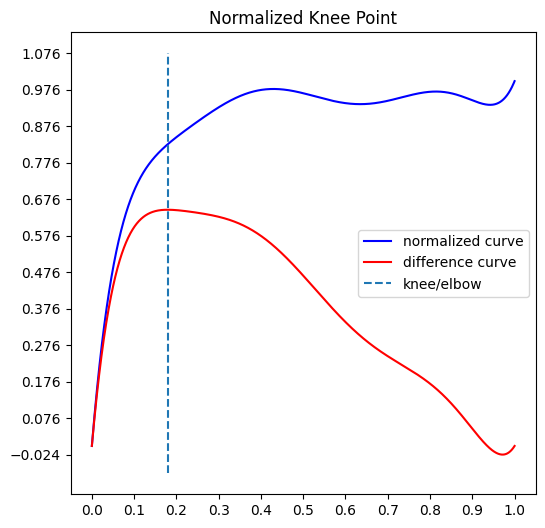

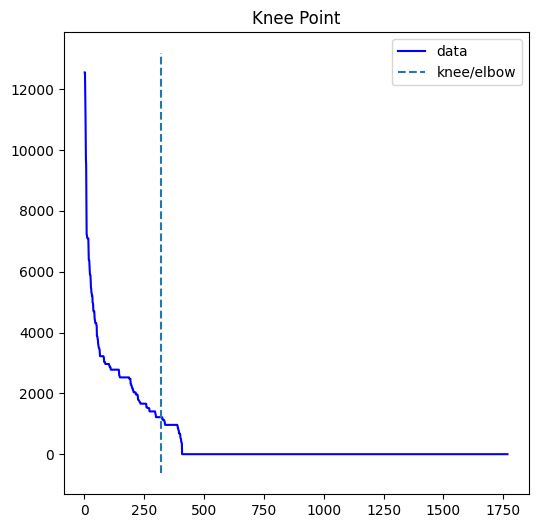

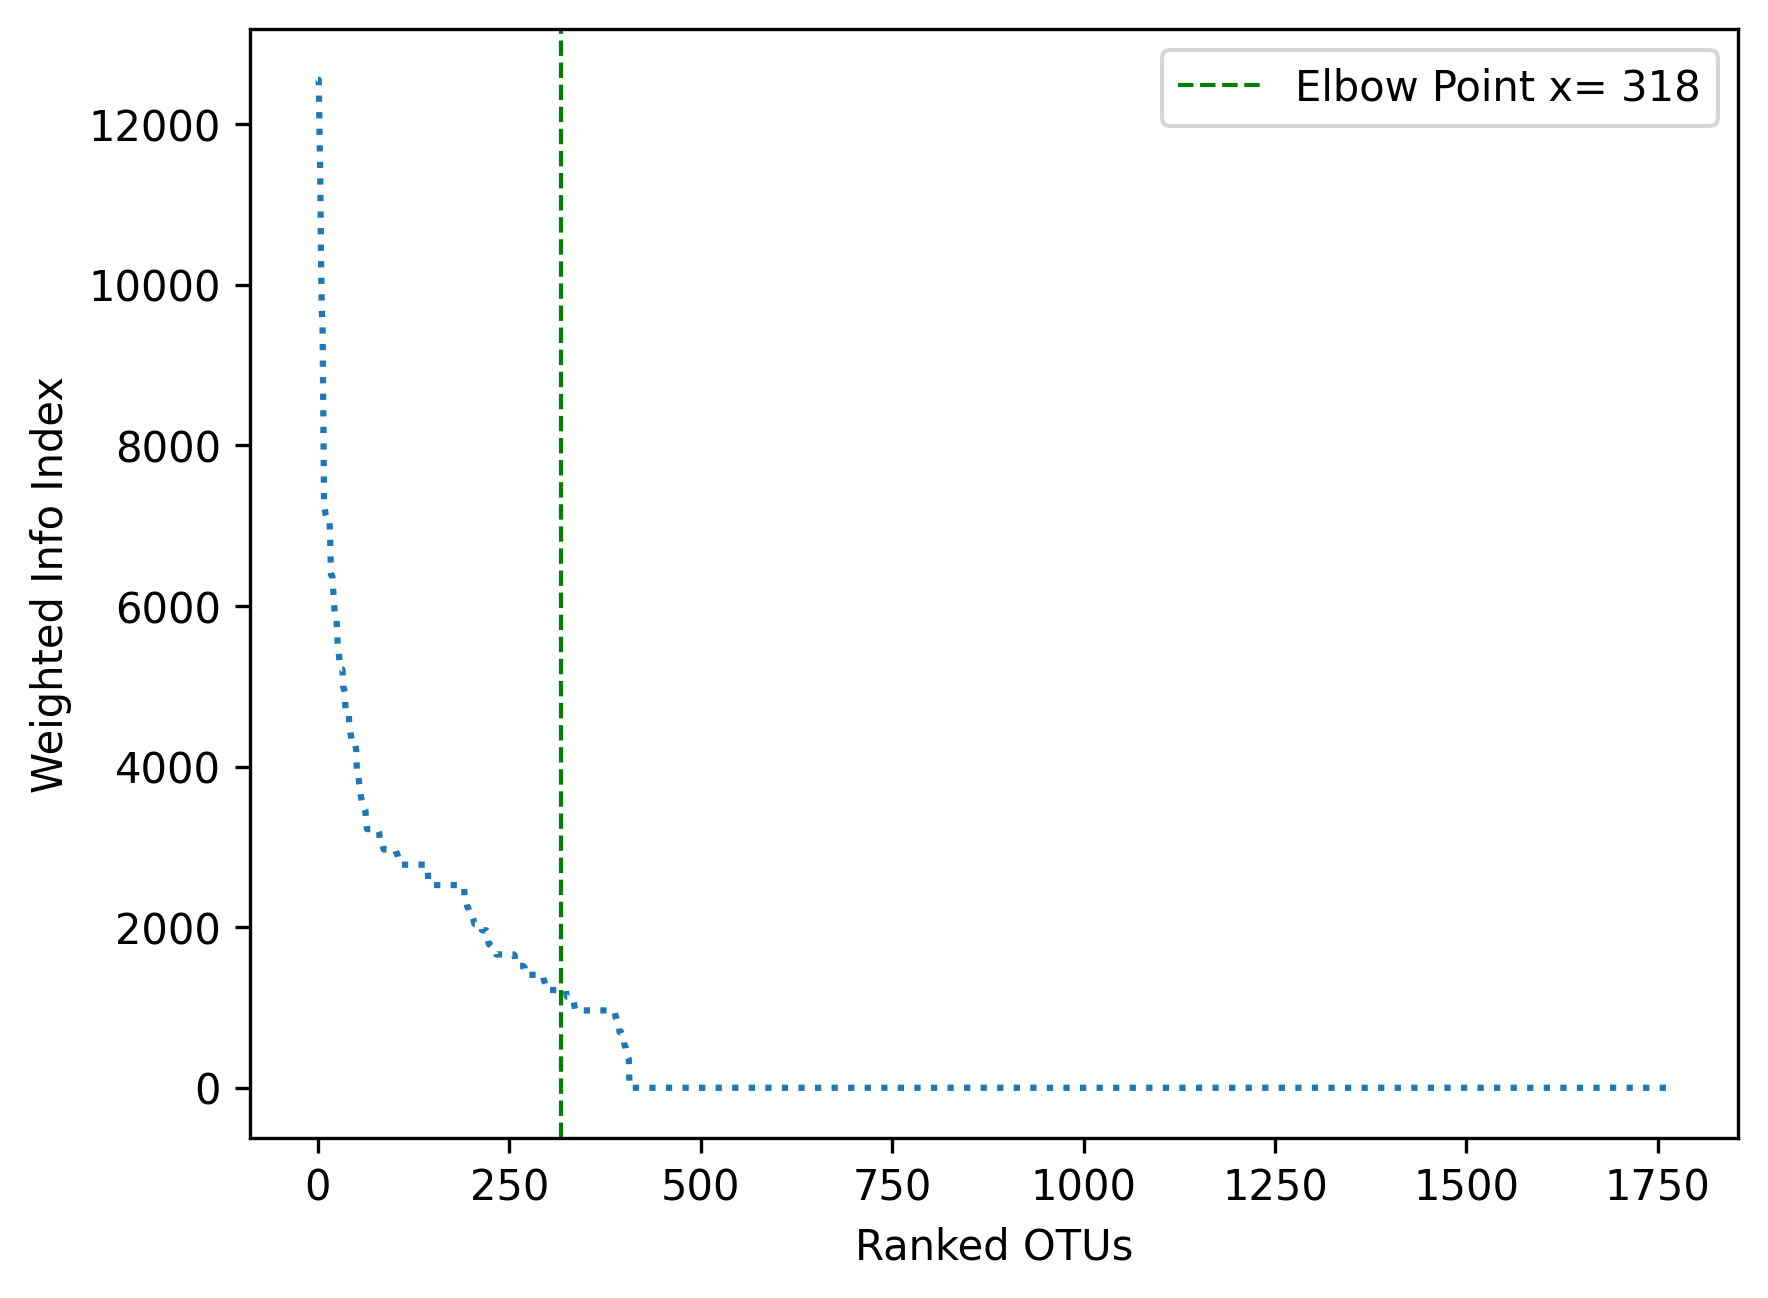

In [9]:
scores=(sorted(weights,reverse=True))
eps=FS.elbowPoint(scores)
FS.plotWeightedIndex(weights,xKnee=eps)


This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [10]:
topFeature_selected=eps
print(eps)

X_FS,selectedOTU_index=FS.feature_select(data,yList,topFeature=topFeature_selected)
print (np.shape(X_FS))


318
(59, 318)


In [13]:
print(len(weights))

1768


In [14]:
clfs = {
    "SVM": svm.SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(random_state=0),
  #  "Logistic Regression": LogisticRegression()
}

In [15]:
targetLabel=un_label 

In [27]:
# Initialize a dictionary to hold AUC scores
auc_scores = {}
for name, clf in clfs.items():
    auc = RunML.CFValidation_AUCstatistic(data,targetLabel,classifier= clf)
    auc_scores[name] = auc
print("AllFeatures",auc_scores)

AllFeatures {'SVM': 0.7263492063492063, 'Random Forest': 0.6865873015873015}


In [28]:
auc_scores = {}
for name, clf in clfs.items():
    auc = RunML.CFValidation_AUCstatistic(X_FS,targetLabel,classifier= clf )
    auc_scores[name] = auc
print("SelectMicro",auc_scores)

SelectMicro {'SVM': 0.7857142857142858, 'Random Forest': 0.6219047619047618}


In [18]:
auc_list  = []
for ii in range(3):
    auc_scores = {}
    randomFeatures=random.sample(list(range(np.shape(data)[1])), topFeature_selected)
    X_randomFeatures=np.array(data)[:,randomFeatures]
    for name, clf in clfs.items():
        auc = RunML.CFValidation_AUCstatistic(X_randomFeatures,targetLabel,classifier= clf )
        auc_scores[name] = auc
    auc_list.append(auc_scores)
auc_pd = pd.DataFrame(auc_list)


In [19]:
print("Random Selection",auc_pd.mean())

Random Selection SVM              0.538360
Random Forest    0.603862
dtype: float64


In [20]:
X_Lasso=RunML.LassoFeatureSelection(data,targetLabel)

In [21]:
len(X_Lasso)

59

In [22]:
print(X_Lasso)

[[1746.    0.    0. ...    0.    0.    0.]
 [1753.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]


In [23]:
auc_scores = {}
for name, clf in clfs.items():
    auc = RunML.CFValidation_AUCstatistic(X_Lasso,targetLabel,classifier= clf )
    auc_scores[name] = auc
print("SelectMicro",auc_scores)

SelectMicro {'SVM': 0.7257142857142858, 'Random Forest': 0.6193650793650793}


In [24]:
auc_list  = []
for ii in range(3):
    auc_scores = {}
    X_Lasso=RunML.LassoFeatureSelection(data,targetLabel)
    for name, clf in clfs.items():
        auc = RunML.CFValidation_AUCstatistic(X_Lasso,targetLabel,classifier= clf )
        auc_scores[name] = auc
    auc_list.append(auc_scores)
auc_pd = pd.DataFrame(auc_list)



In [25]:
print("LASSO Selection",auc_pd.mean())


LASSO Selection SVM              0.725714
Random Forest    0.619365
dtype: float64


## result 1 roc curve with variance

### on urban and Natural factor

In [29]:
clf=RandomForestClassifier(random_state=0)
targetLabel=un_label                             

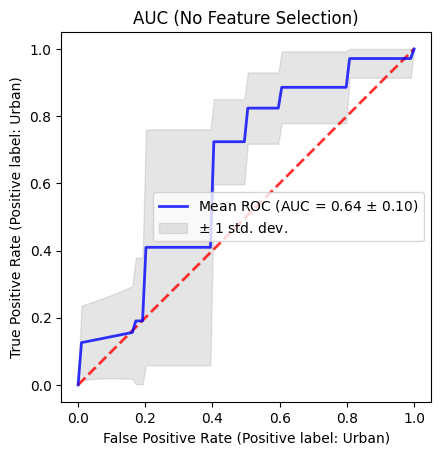

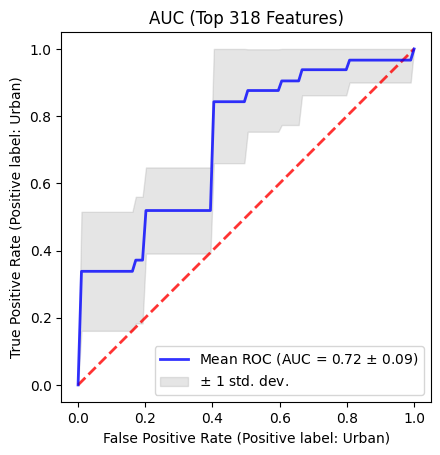

In [30]:
# plot for random forest for all features and SelectMicro
RunML.CrossFoldValidation_AUC(data,targetLabel,title="AUC (No Feature Selection)",classifier=clf)
RunML.CrossFoldValidation_AUC(X_FS,targetLabel,title=f'AUC (Top {eps} Features)',classifier=clf)
  

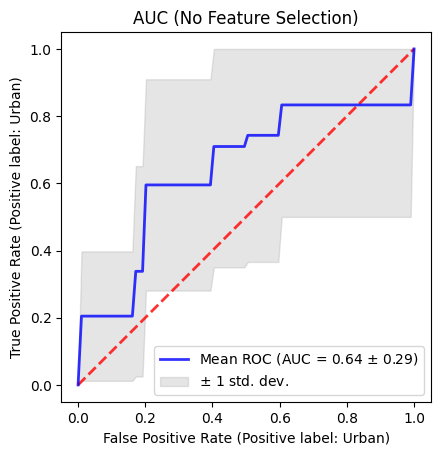

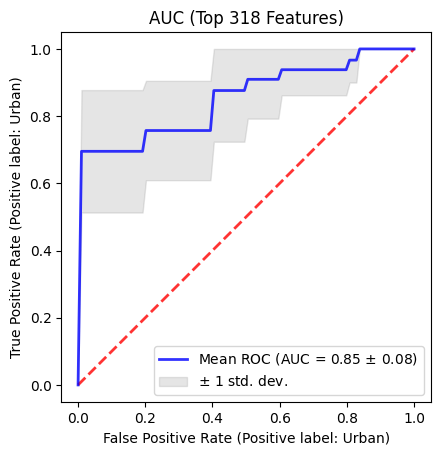

In [31]:
## plot for SVM for all features and SelectMicro
RunML.CrossFoldValidation_AUC(data,targetLabel,title="AUC (No Feature Selection)")
RunML.CrossFoldValidation_AUC(X_FS,targetLabel,title=f'AUC (Top {eps} Features)')

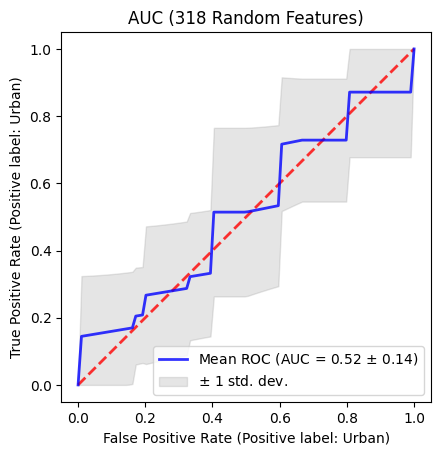

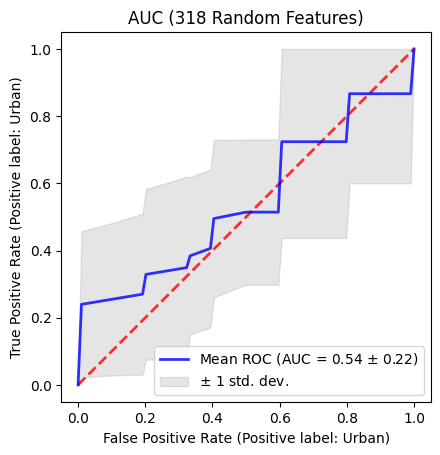

In [32]:
randomFeatures=random.sample(list(range(np.shape(data)[1])), topFeature_selected)
X_randomFeatures=np.array(data)[:,randomFeatures]
RunML.CrossFoldValidation_AUC(X_randomFeatures,targetLabel,title="AUC (318 Random Features)",classifier=clf)
RunML.CrossFoldValidation_AUC(X_randomFeatures,targetLabel,title="AUC (318 Random Features)")

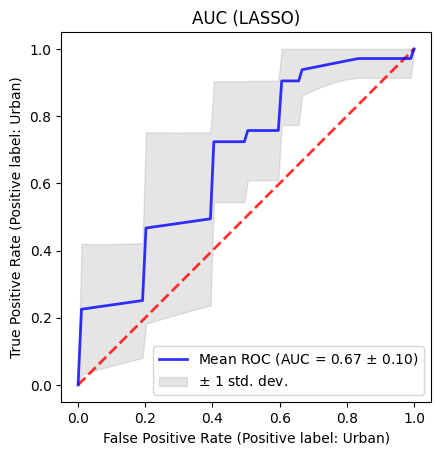

In [33]:
# random forest and SVM result for lasso selection: 
#for now, only the random forest AUC value is same with the value in table 1 which I calculated  using functions.
X_Lasso=RunML.LassoFeatureSelection(data,targetLabel)
RunML.CrossFoldValidation_AUC(X_Lasso,targetLabel,title="AUC (LASSO)",classifier=clf)

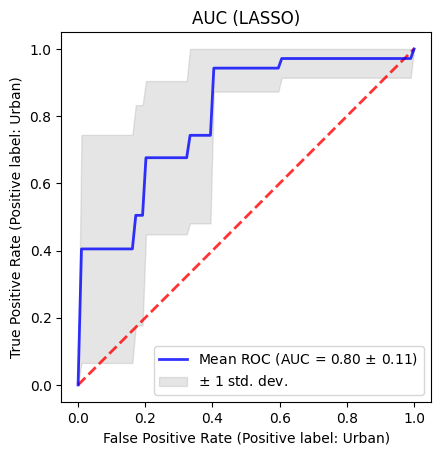

In [34]:
RunML.CrossFoldValidation_AUC(X_Lasso,targetLabel,title="AUC (LASSO)")

### on burn label

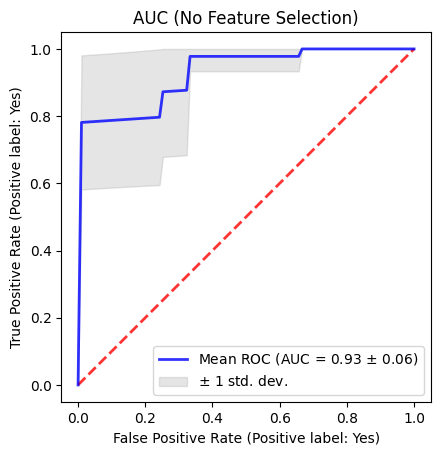

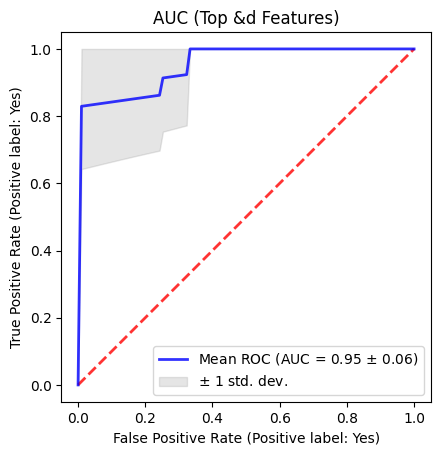

In [35]:
#test on burn label
targetLabel=burn_label

RunML.CrossFoldValidation_AUC(data,targetLabel,title="AUC (No Feature Selection)",classifier=clf)
RunML.CrossFoldValidation_AUC(X_FS,targetLabel,title="AUC (Top &d Features)",classifier=clf)
    

## Confusion matrix for 3 factors using RF

In [36]:
clf=RandomForestClassifier(random_state=0)

CF matrix has group names


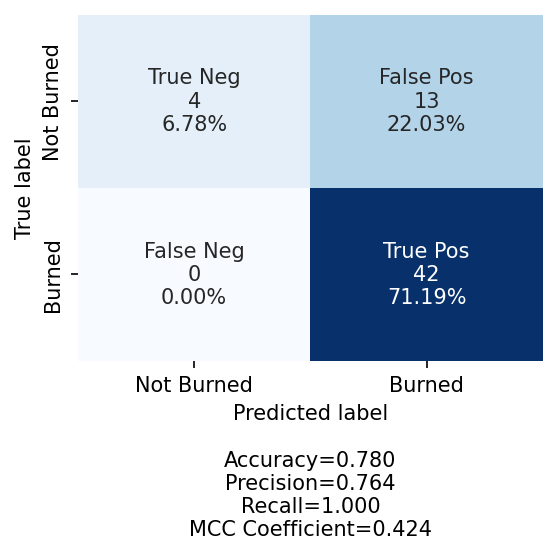

CF matrix has group names


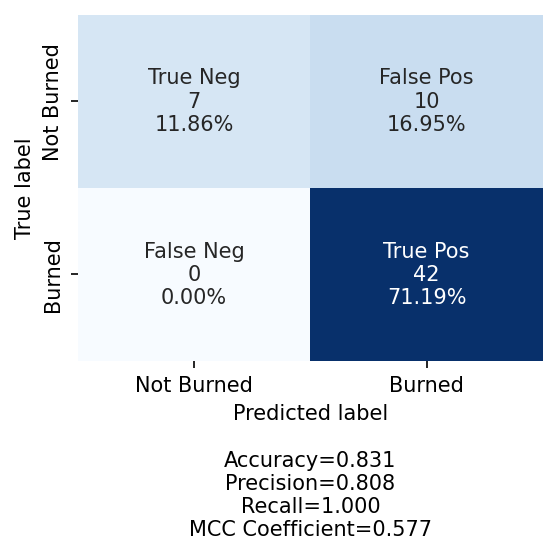

In [37]:
cat=["Not Burned","Burned"] 
targetLabel=burn_label
RunML.classificationHeatMap(data,targetLabel,cat,classifier=clf,title="")
RunML.classificationHeatMap(X_FS,targetLabel,cat,classifier=clf,title="")

CF matrix has group names


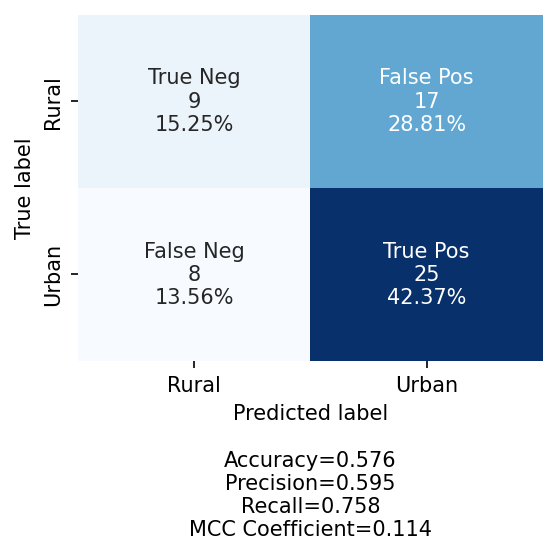

CF matrix has group names


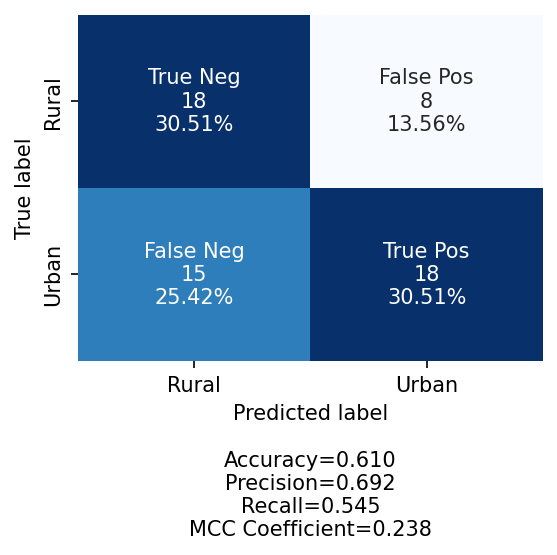

In [38]:
cat=["Rural","Urban"]
targetLabel=un_label
RunML.classificationHeatMap(data,targetLabel,cat,classifier=clf,title="")
RunML.classificationHeatMap(X_FS,targetLabel,cat,classifier=clf,title="")

CF matrix has group names


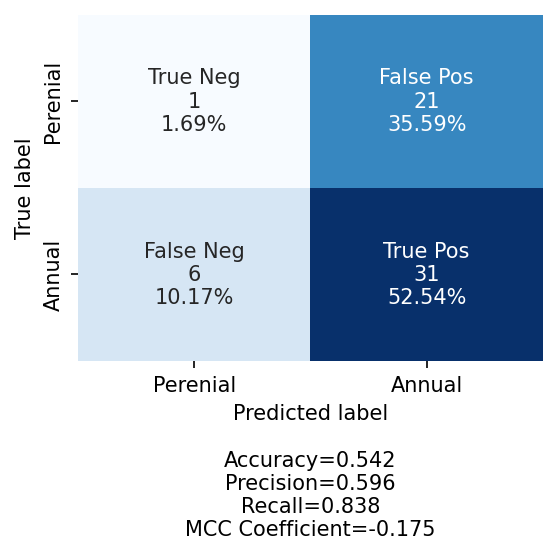

CF matrix has group names


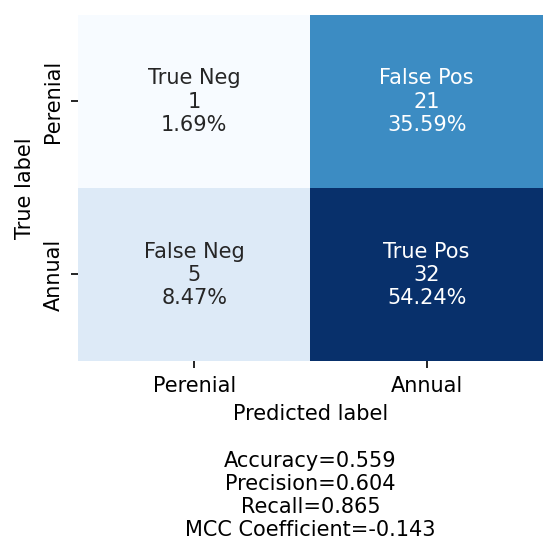

In [39]:
cat=["Perenial","Annual"]   
targetLabel=duration_label
RunML.classificationHeatMap(data,targetLabel,cat,classifier=clf,title="")
RunML.classificationHeatMap(X_FS,targetLabel,cat,classifier=clf,title="")

## compare the first 15 index

{'Yes', 'No'}
42 17


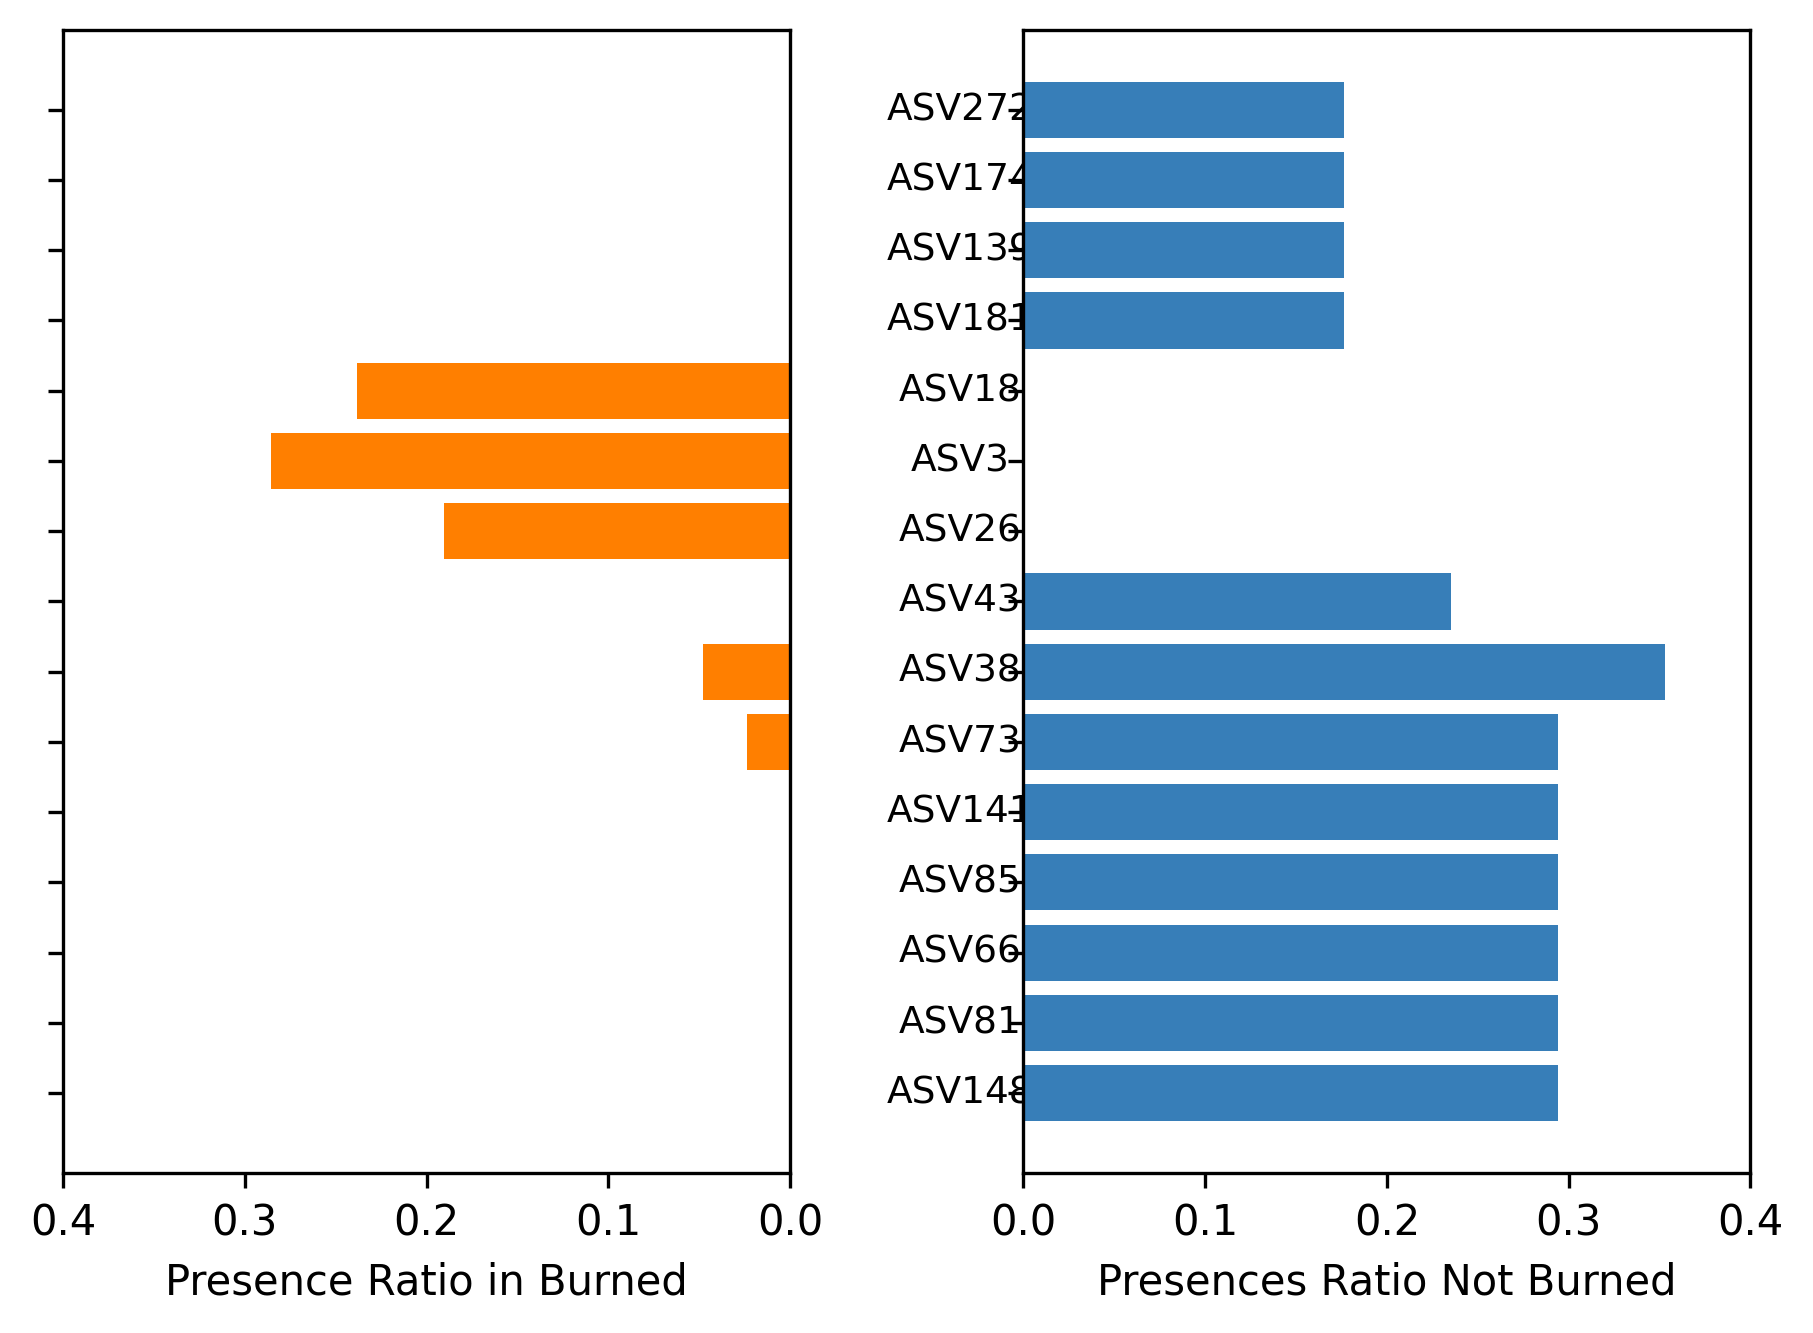

{'Natural', 'Urban'}
33 26


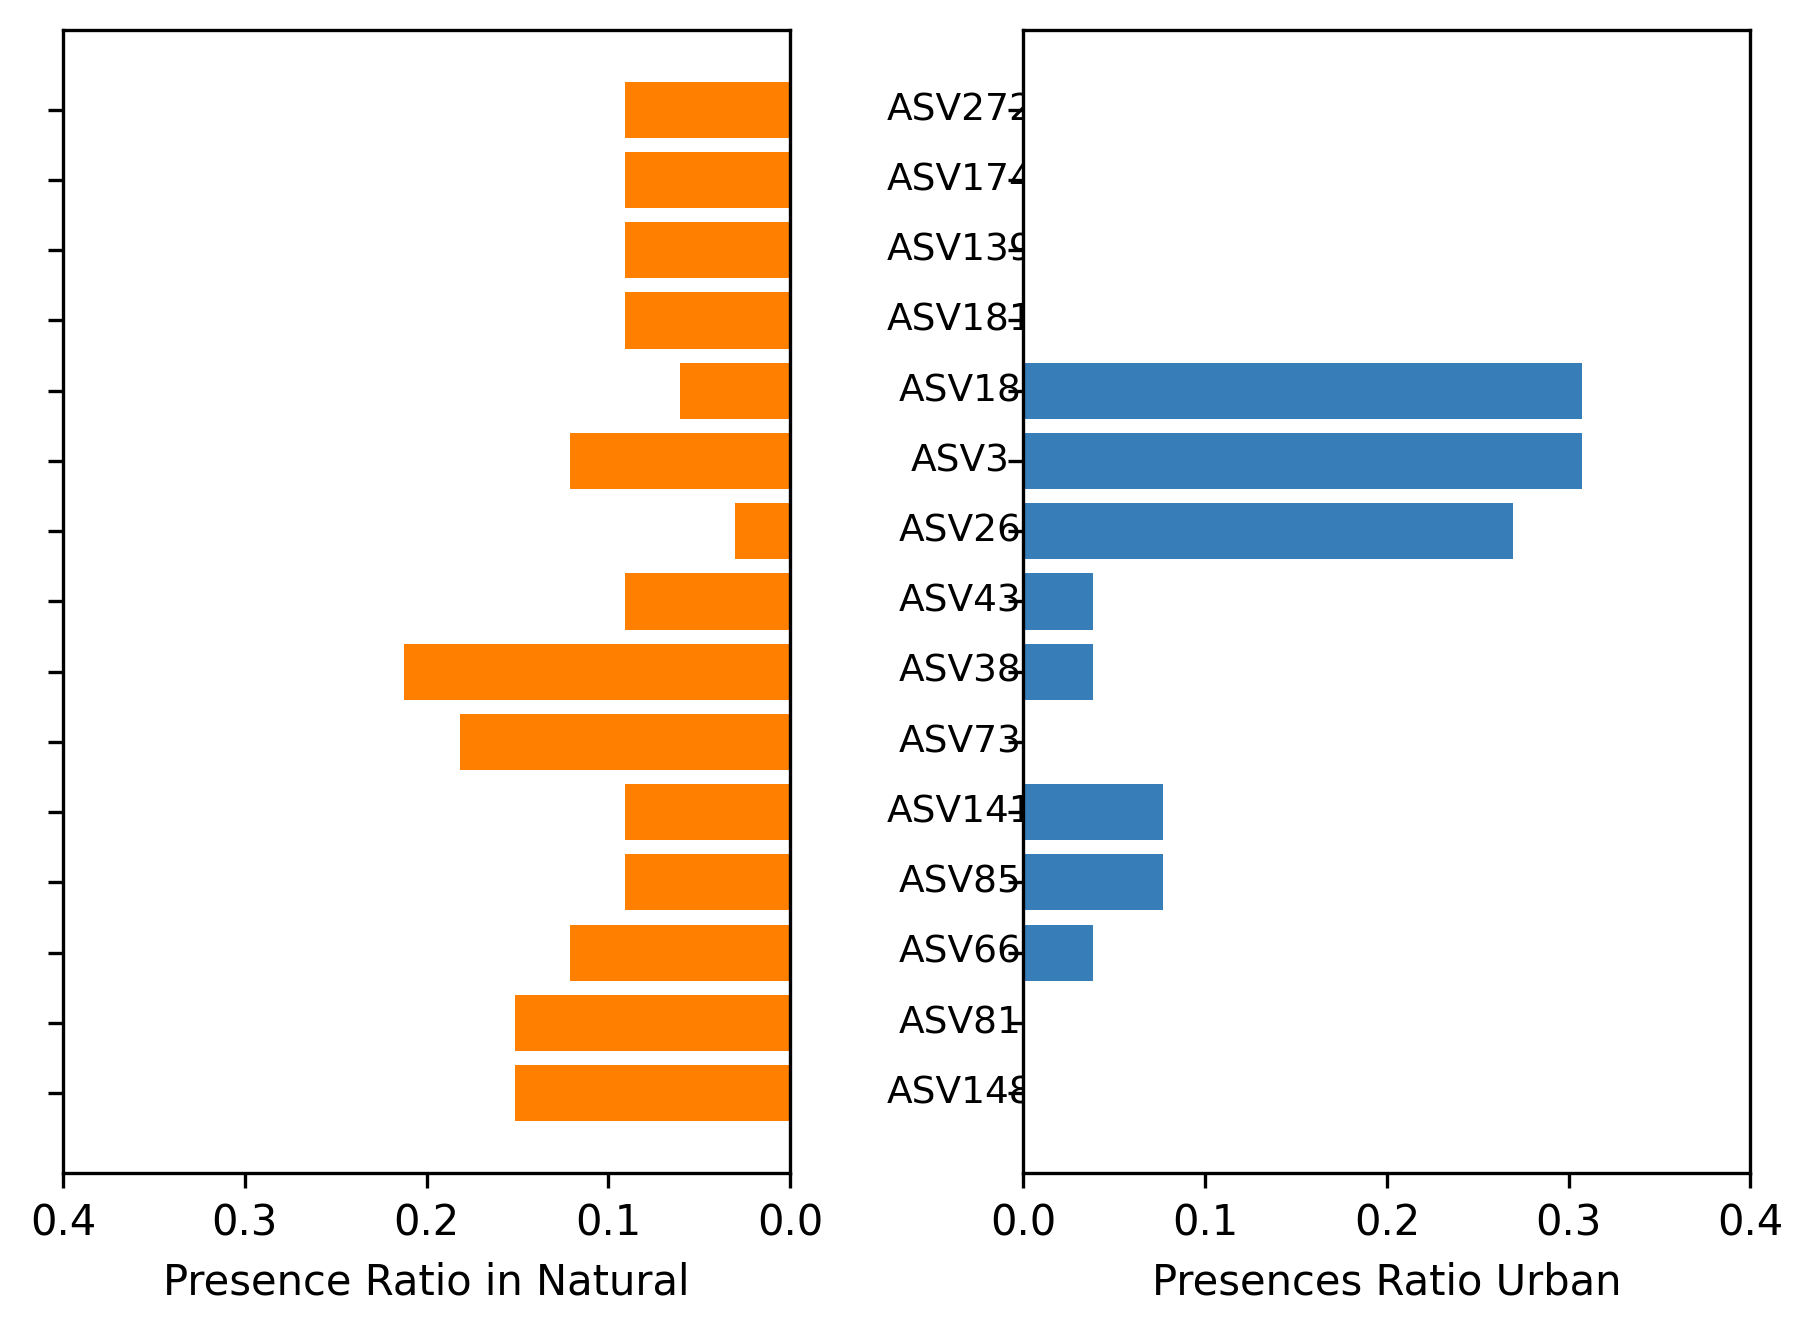

{'Perennial', 'Annual'}
22 37


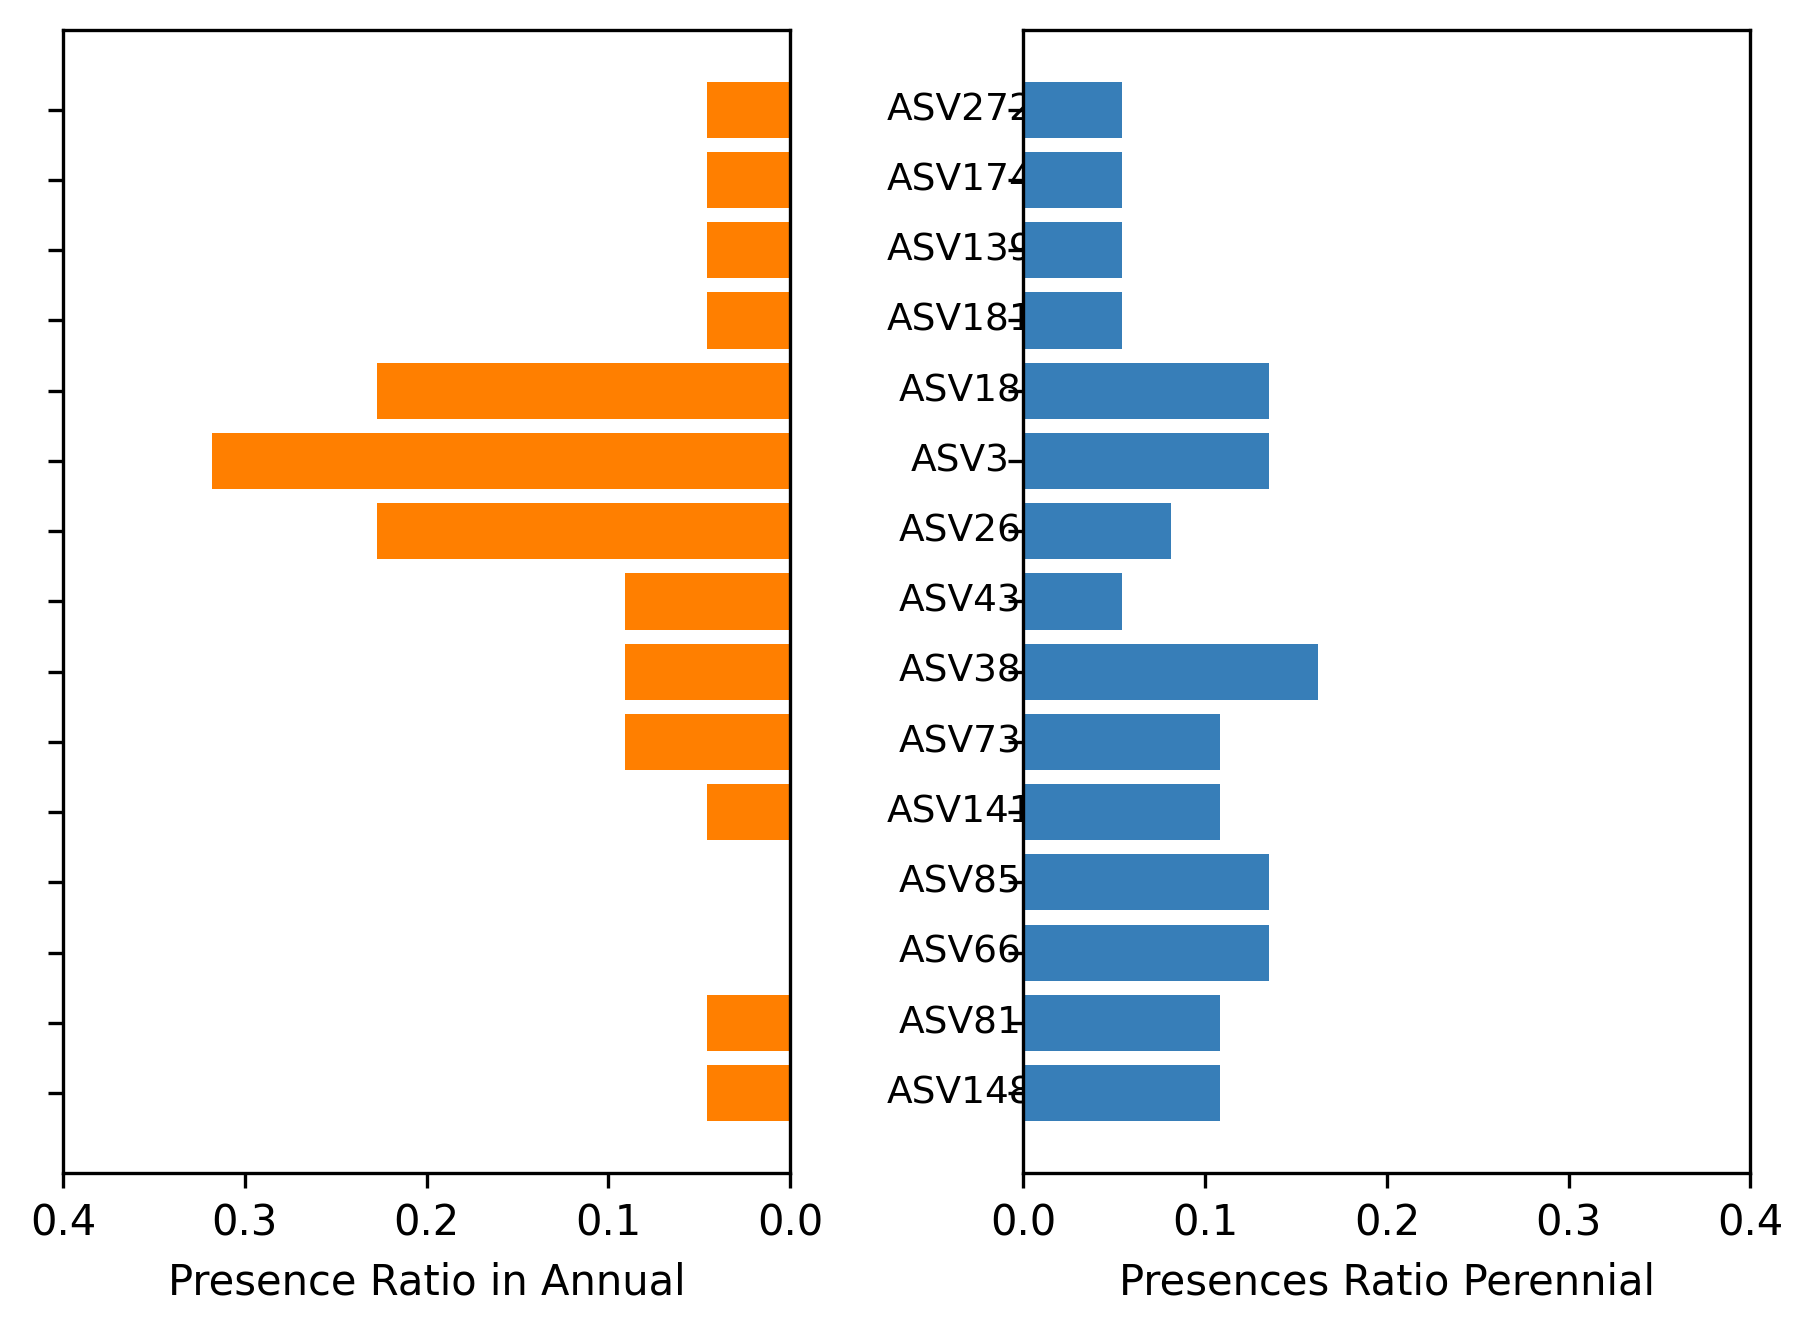

In [40]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]

df=pd.DataFrame(data=X_FS_15)
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

targetLabel=burn_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Yes",posText="Burned",negText="Not Burned",entries=entries)

targetLabel=un_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Urban",posText="Natural",negText="Urban",entries=entries)


targetLabel=duration_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Annual",posText="Annual",negText="Perennial",entries=entries)


                
                
    
